# Combined Population Health and Service Capacity Model

## Overview

This notebook contains the code to develop and test the MGSR.

Further details on the development of the population health model can be found [here](./population_health_model.ipynb), and the service capacity model can be found [here](./capacity_model.ipynb).

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore') 

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]])
               if '/' in c else c for c in dta.columns]

In [5]:
dta.shape

(1618, 13)

## Function to group data 

In [6]:
def group_data(data, features):

    features = ['population',
                'People', 'Places',
                'Lives']


    #ensure no identical points in train and test

    grouped = pd.DataFrame()
    
    for pop, group in data.groupby('population'):

        #if len(group.lives.unique())>1:

            #print('multiple CCG with same population')

        ccg_year = pd.Series(dtype='float64')

        for f in features:

            ccg_year[f] = group[f].unique()[0]

        ccg_year['ae_attendances_attendances']\
        = group.ae_attendances_attendances.mean()
        

        grouped = grouped.append(ccg_year, ignore_index=True)
        
    return grouped

## Fit Predict Population Health model

In [7]:
model = RandomForestRegressor(max_depth=4, n_estimators=2, 
                              random_state=0)

pophealth_features = ['population',
                    'People', 'Places', 'Lives']

grouped = group_data(dta, pophealth_features)

y = grouped['ae_attendances_attendances']

X = grouped[pophealth_features]

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
results = pd.DataFrame()


scores_train, scores_test, feat = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    test = X.iloc[test_index].copy()
    test['ae_predicted'] = model.predict(X.iloc[test_index])
    
    results = results.append(test, ignore_index=True)

In [8]:
results

,population,People,Places,Lives,ae_predicted
0,14.9084,96.000000,99.500,94.600000,911.450934
1,20.5985,95.500000,102.300,100.300000,539.392222
2,20.9547,101.100000,101.600,101.300000,539.392222
3,21.6203,96.600000,96.800,94.600000,423.850911
4,26.1061,88.600000,94.800,91.900000,833.715369
...,...,...,...,...,...
140,137.0653,93.680000,98.580,91.620000,489.742472
141,150.2535,104.566667,100.850,104.100000,321.867013
142,151.1457,101.740000,96.820,97.540000,493.119675
143,181.1249,100.916667,97.550,99.133333,493.119675


### Merge with data set 

In [9]:
dta = dta.merge(results[['population','ae_predicted']],\
                left_on='population', right_on='population')

## Combined model 

In [10]:
#capacity utility model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=6, 
                            random_state=0)

#combinator
final = LinearRegression()

train, test = train_test_split(dta,random_state=29)

#split training data into two sets
train_0, train_1 = train_test_split(train, train_size=0.75, 
                                    random_state=29)



#capacity utility
capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

pophealth_features = ['population',
                    'People', 'Places', 'Lives']

#train capacity modeel

y_0 = train_0['ae_attendances_attendances']
X_0 = train_0[capacity_features]

rf1.fit(X_0,y_0)


#predict

y_pred_cu = rf1.predict(train_1[capacity_features])

print(rf1.score(train_1[capacity_features], 
                train_1['ae_attendances_attendances']))

y_pred_ph = train_1['ae_predicted']


0.4519048888936743


In [11]:
X_f = np.vstack([y_pred_cu, y_pred_ph]).T
y_f = train_1['ae_attendances_attendances']

final.fit(X_f,y_f)

final.score(X_f,y_f)

0.7360370197755353

### Check performance on held out data 

In [12]:
from sklearn.metrics import r2_score as r2

y_pred_cu = rf1.predict(test[capacity_features])

print(rf1.score(test[capacity_features], 
                test['ae_attendances_attendances']))

#y_pred_ph = rf2.predict(test[pophealth_features])

y_pred_ph = test['ae_predicted']

print(r2(test['ae_attendances_attendances'], test['ae_predicted']))

y_pred_final = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)

#print(r2_score(test['ae_attendances_attendances'], y_pred_final))

print(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,
                  test['ae_attendances_attendances']))

0.4227235191823048
0.5791158305719311
0.6661669967506625


### Coefficients 

In [13]:
final.coef_

array([0.51639993, 0.72968426])

## Combined model with optimised parameters 

In [14]:
def fit_ph(dta, features, model):
    
    if 'ae_predicted' in dta.columns:
        
        dta = dta.drop(['ae_predicted'], axis=1)
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    # dont set random state so that function can be used in overall cv
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    results = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        test = X.iloc[test_index].copy()
        
        test['ae_predicted'] = model.predict(X.iloc[test_index])
    
        results = results.append(test, ignore_index=True)
        
    dta = dta.merge(results[['population','ae_predicted']],
                    left_on='population', right_on='population')
        
    return dta

In [15]:
def fit_capacity(dta, features, model):
    
    y = dta['ae_attendances_attendances']
    X = dta[features]

    model.fit(X,y)
    
    return model

In [16]:
def fit_combined(train, rf1, m1_features, train_size=7/8):
    
    final = LinearRegression()

    #split training data into two sets
    train_0, train_1 = train_test_split(train, 
                                        train_size=train_size, 
                                        random_state=29)

    #train capactiy model
    
    rf1 = fit_capacity(train_0, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(train_1[m1_features])

    
    #use pre-predicted average attendances
    
    y_pred_2 = train_1['ae_predicted']
        
    #final
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = train_1['ae_attendances_attendances']

    final.fit(X_f,y_f)
    
    return rf1,final        

In [17]:
def cv_combined(dta, rf1, rf2):
    
    # splitter for cross validation 
    
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_final, scores_rf1, scores_rf2, coefs = [],[],[],[]
    
    k=1
    
    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    dta_pred = pd.DataFrame()
    
    #fit population health independently to avoid data leakage
    
    dta = fit_ph(dta, pophealth_features, rf2)
    
    print(dta.shape)
    
    for train_index, test_index in cv.split(dta):
        
        #print(f'\n Split {k} \n')
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]

        #final models
        rf1, final = fit_combined(train, rf1, capacity_features)
        
        coefs.append(final.coef_)
        
        #predict on test data
        
        y_pred_cu = rf1.predict(test[capacity_features])

        scores_rf1.append(rf1.score(test[capacity_features],
                                    test['ae_attendances_attendances']))

        y_pred_ph = test['ae_predicted']

        scores_rf2.append(r2(test['ae_attendances_attendances'],
                             test['ae_predicted']))
        
        preds = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)

        scores_final.append(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,
                                        test['ae_attendances_attendances']))
        
        test_pred = test.copy()
        test_pred['predicted'] = preds
        test_pred['true'] = test['ae_attendances_attendances'].values
        
        test_pred['iter'] = [k for i in test_pred.index]
        
        dta_pred = dta_pred.append(test_pred, ignore_index=False)
        
        
        k+=1
        
    return scores_final, scores_rf1, scores_rf2, dta_pred, coefs

In [18]:
#capacity model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=6, random_state=0)

#population health model
rf2 = RandomForestRegressor(max_depth=4, n_estimators=2, random_state=0)

scores_final, scores_rf1, scores_rf2, \
dta_pred, coefs = cv_combined(dta, rf1, rf2)

(1618, 14)


### Results for paper

In [19]:
results=pd.DataFrame()

results['final'] = scores_final

In [20]:
results.describe()

,final
count,25.000000
mean,0.665444
std,0.039768
min,0.573507
25%,0.631816
50%,0.675520
75%,0.696484
max,0.732708


### Coefficient importances 

#### Mean 

In [21]:
np.mean(coefs, axis=0)

array([0.45512963, 0.63355856])

#### Std 

In [22]:
np.std(coefs, axis=0)

array([0.08806844, 0.12641045])

### Plot 

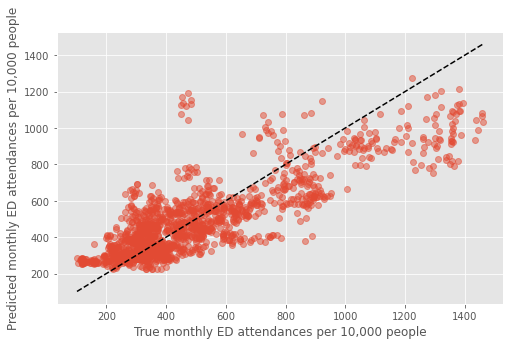

In [23]:
fig,ax = plt.subplots(figsize=(8,5))

mean_pred, true = [],[]

for i in dta_pred.index.unique():
    
    mean_pred.append(dta_pred.loc[i]['predicted'].mean())
    true.append(dta_pred.loc[i]['true'].mean())

plt.plot(true, mean_pred, 'o', alpha=0.5)

xx = np.arange(min(dta_pred['true']),max(dta_pred['true']))
plt.plot(xx,xx,'k--')

plt.xlabel('True monthly ED attendances per 10,000 people')
plt.ylabel('Predicted monthly ED attendances per 10,000 people')
plt.savefig('true_predicted_combined.png')
plt.show()

## Permutation Feature Importance 

In [24]:
def fit_ph_shuffle(dta, features,f, model):
    
    if 'ae_predicted' in dta.columns:
        
        dta = dta.drop(['ae_predicted'], axis=1)
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]
    
    X_shuffled = X.copy()
    
    X_shuffled[f] = np.random.permutation(X[f].values)
    
    
    # dont set random state so that function can be used in overall cv
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    results = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        test = X.iloc[test_index].copy()
        
        test['ae_predicted'] = model.predict(X_shuffled.iloc[test_index])
    
        results = results.append(test, ignore_index=True)
        
    dta = dta.merge(results[['population','ae_predicted']],
                    left_on='population', right_on='population')
        
    return dta

In [25]:
def permeate_feature(dta, f,rf1, rf2):
    
    
    shuffled = dta.copy()

    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    if f in capacity_features:
    
        shuffled[f] = np.random.permutation(dta[f].values)
    
    else:
        
        shuffled = fit_ph_shuffle(shuffled, pophealth_features,f, rf2)
        
    
    dta = fit_ph(dta, pophealth_features, rf2)
    
    # splitter for cross validation
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    #importances = pd.DataFrame()
    
    shuffled_score, true_score  = [],[]
    
    #print(f'running for {f} \n')
    
    for train_index, test_index in cv.split(dta):
        
        test_shuffled = shuffled.iloc[test_index]
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]
        
        
        #final models
        rf1, final = fit_combined(train, rf1, capacity_features)

        
        
        #predict on test data
        
        y_pred_cu = rf1.predict(test[capacity_features])

        y_pred_ph = test['ae_predicted']
        
        y_pred_cus = rf1.predict(test_shuffled[capacity_features])
        
        if f in capacity_features:

            y_pred_phs = test['ae_predicted']
            
        else:
            
            y_pred_phs = test_shuffled['ae_predicted']
            
        
        true_score.append(
            final.score(np.vstack([y_pred_cu, y_pred_ph]).T,\
                                                test['ae_attendances_attendances']))
        
        shuffled_score.append(
            true_score[-1] - final.score(np.vstack([y_pred_cus, y_pred_phs]).T,\
                                            test['ae_attendances_attendances']))
        
    #print(f'{f} complete\n')
    
    return true_score, shuffled_score       

In [26]:
def feature_importance_combined(dta, rf1, rf2):
    
    importances = pd.DataFrame()
    
    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
    #            '111_111_answered', 'amb_sys_made']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    
    for f in capacity_features + pophealth_features:
        
        
        true_score, shuffled_score = permeate_feature(dta, f,rf1, rf2)
        
        if 'score' in importances.columns:
        
            importances['score'] = np.mean([importances['score'].values, true_score],axis=0)
            
        else:
            
            importances['score'] = true_score
            
        importances[f] = shuffled_score
  

    return importances

In [27]:
#set random seed to make results reproducible
np.random.seed(4)

importances = feature_importance_combined(dta, rf1, rf2)

In [28]:
importances.describe()

,score,gp_appt_available,111_111_offered,amb_sys_answered,population,People,Places,Lives
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.665444,0.038496,0.065235,0.168881,0.314797,0.060245,0.056963,0.136148
std,0.039768,0.017823,0.023436,0.060690,0.083262,0.020495,0.019350,0.033684
min,0.573507,0.008636,0.024123,0.008525,0.184795,0.025377,0.032113,0.063237
25%,0.631816,0.022420,0.049155,0.128301,0.261576,0.047641,0.047347,0.109393
50%,0.675520,0.045330,0.064777,0.176024,0.291522,0.057505,0.052506,0.142293
75%,0.696484,0.051860,0.088824,0.200768,0.368699,0.078592,0.061810,0.158519
max,0.732708,0.071707,0.101177,0.294804,0.519668,0.105991,0.106355,0.194395


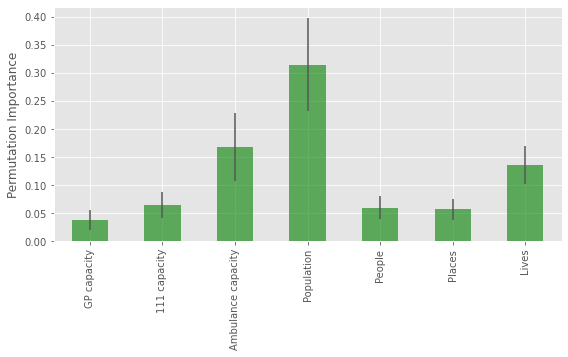

In [29]:
fig,ax = plt.subplots(figsize=(8,5))

importances[importances.columns[1:]].describe().loc['mean'].plot(kind='bar', \
            yerr = importances[importances.columns[1:]].describe().loc['std'],\
                            alpha=0.6, color='g',ax=ax)

plt.ylabel('Permutation Importance', fontsize=12)
plt.tight_layout()

tick_labels = ['GP capacity','111 capacity', 'Ambulance capacity',\
               'Population', 'People', 'Places', 'Lives']

ax.set_xticklabels(tick_labels)

plt.savefig('importance.png')
plt.show()

## Train final model on all data and save for forecasting 

In [30]:
def fit_final(dta, rf1, rf2, m1_features, m2_features):
    
    
    final = LinearRegression()


    #train capactiy model
    
    rf1 = fit_capacity(dta, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(dta[m1_features])

    
    
    grouped = group_data(dta, m2_features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[m2_features]

    rf2.fit(X, y)
    
    y_pred_2 = rf2.predict(dta[m2_features])
        
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = dta['ae_attendances_attendances']

    final.fit(X_f,y_f)

    print('Combined training score:',final.score(X_f,y_f))
    
    return rf1,rf2, final        

In [31]:
m1_features = capacity_features
m2_features = pophealth_features

rf1,rf2,final = fit_final(dta, rf1, rf2, m1_features, m2_features)

Combined training score: 0.8171513959512132


In [32]:
with open('stacked_model_scaled.pkl','wb') as f:
    
    pkl.dump([[rf1,rf2,final], m1_features, m2_features], f)